# Clapping coordination in audience

Assessing the quality of clapping during the final applause of the DSQ concert using motion recordings of individual audience members that capture each clap.

This interval shows different clapping patterns, initial scattered enthusiastic clapping, then synchronised clapping for more than a minute, and then scattering again. 

In [52]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act

## Load final clapping section
individual claps

In [678]:
os.listdir('./Data/Final_clapping_section_accelerometer')

['final_section_trimmed.csv',
 'final_section_peaks.csv',
 'notes.txt',
 'final_section_stats.csv',
 'final_Stage_events.csv',
 'final_section_motion.csv']

In [733]:
# note these time are approximate to around the second. Shoudl be confirmed with better video interface than youtube
musician_times = pd.read_csv('./Data/Final_clapping_section_accelerometer/Final_Stage_events.csv',",") #SV alignment for beeps
musician_times

TIME       LABEL
0     7.0       Stand
1    11.0         Bow
2    16.0        Team
3    20.0         Bow
4    24.0   De-equipe
5    41.0         Bow
6    53.0     Leaving
7    61.0    Offstage
8    76.0   Returning
9    85.0         Bow
10   93.0        Team
11  101.0         Bow
12  108.0     Leaving
13  111.0    Offstage

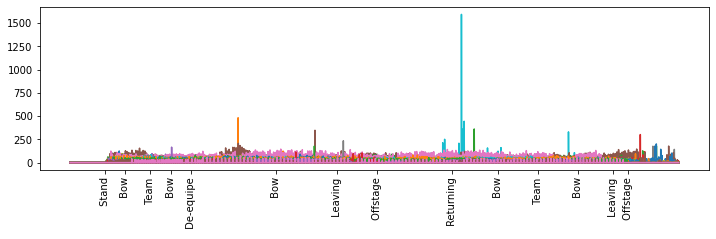

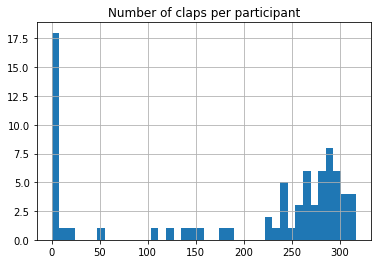

[77, 59]


In [683]:
peaks = pd.read_csv('./Data/Final_clapping_section_accelerometer/final_section_peaks.csv')
#peaks= peaks.set_index('index',drop = True)
peaks = peaks.fillna(0)
ts = pd.Series(np.arange(0,len(peaks))*0.02)
df_claps = pd.DataFrame(index = ts,data = peaks.drop('index',1).values)
df_claps.plot(figsize = [12,3],legend = False)
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')

plt.show()
df_OnlyClaps = df_claps.astype(bool).astype(int)

df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>0])])
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>0]]
df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)


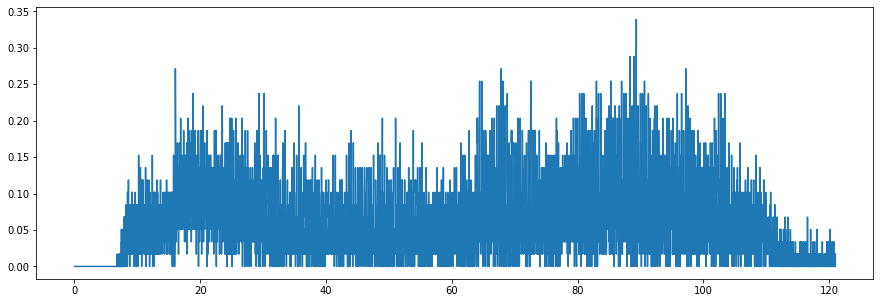

In [505]:
# sample level counting 
FrameSize = 0.02
HopSize = 0.02
Thresh = 0.5
actType = 'UBound'
Acts = act.activityCount(df_claps,FrameSize,HopSize,Thresh,actType)
Acts = Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total'])
Acts['Total'].plot(figsize=[15,5])
plt.show()

Even though the alignment precesion for these claps is not very high (~100ms), the alignment was still sufficient to allow claps to congregate exceptionally, showing the audience come together.

It would be possible to improved the results by removing the clapless recordings (done) and to improve the alignment of responses with cross correlations. Might not be necessary though, as sequential regularity might be more predictive within individual clapping sequences. 

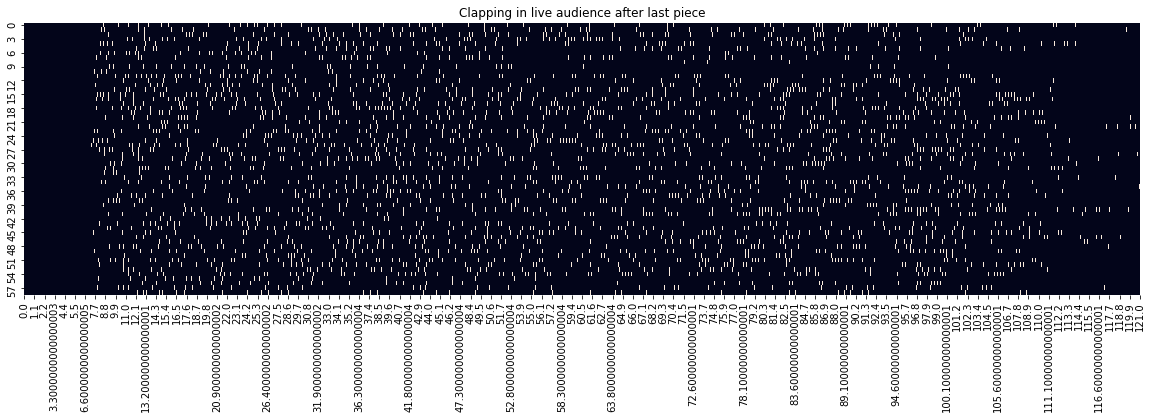

In [316]:
fig, ax = plt.subplots(figsize = [20,5])
chart = sns.heatmap(data=df_claps.transpose(), ax=ax,vmin=0, vmax=1,cbar=False)
#plt.xticks(concert_times.datetime_concert,concert_times.event, rotation='vertical')
#freq = int(round(len(aud_df)/len(ax.get_xticks())))
#ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Clapping in live audience after last piece')
#plt.savefig('claptimes_finale.png')
plt.show()

## Coincidental clapping assessment

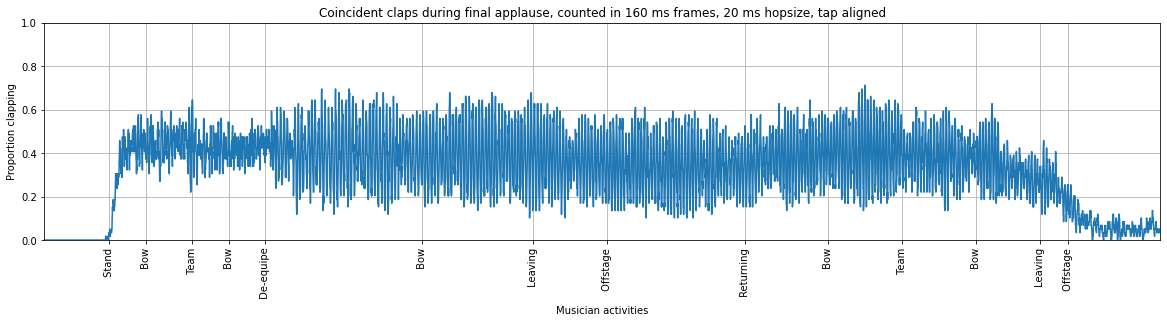

In [684]:
FrameSize = 0.16
HopSize = 0.02
Thresh = 0.5
alpha = 0.01
actType = 'UBound'
ShuffleRange = 2
Iter = 500
Acts = act.activityCount(df_claps,FrameSize,HopSize,Thresh,actType)
Acts = Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total'])
Acts['Total'].plot(figsize=[20,4])
plt.title('Coincident claps during final applause, counted in 160 ms frames, 20 ms hopsize, tap aligned')
#plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.xlabel('Musician activities')

plt.ylabel('Proportion clapping')
plt.xlim([0,121])
plt.ylim([0,1])
plt.grid()

In [688]:
actType = 'UBound'
HopSize = 0.02
Thresh = 0.5
FrameSize = 0.1
Acts=act.activityCount(df_claps,FrameSize,HopSize,Thresh,actType)
Acts= Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total'])

In [689]:
ShuffleRange = 1
Iter = 1000
alpha = 0.005

stest = act.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
#stest

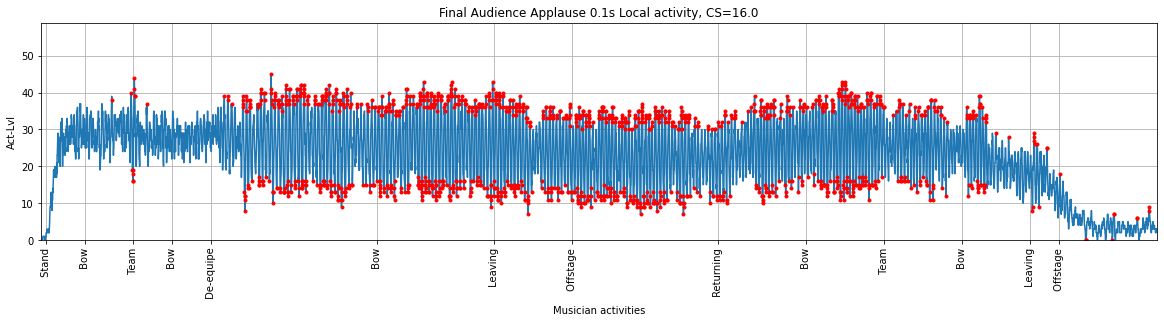

In [690]:
A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
fig = A['Activity-levels'].plot(figsize=[20,4])
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.')
else:
    B['Activity-levels'].plot(style='y.')
plt.ylim([0,59])
plt.xlim([6.5,121])
#plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.xlabel('Musician activities')
plt.ylabel('Act-Lvl')
plt.grid()
plt.title('Final Audience Applause ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
plt.savefig('Applause_Final_Alignment_005_musicanEvents.png',dpi = 400)
plt.show()

Coordination of claps across participants was performed using the activity analysis local test of coordination. Figure 1.1 reports the number of participants measured as clapping in a sliding 100 ms window of synchrony, with red point marking when these coincidences exceed a probabilistic threshold of 0.005 for accidental alignment (given the local rates of claps on a shuffle range of 1 s and 1000 alternatives). The number of claps rises quickly and maintains a blury range of 23-36 of 59 with few extreme coincidences (13.7, 15.7-16.2), until coordinated clapping starts to coalesce from 25.3 s and reaches a steady regularity at 27.2 s. This extreme alignment continues through to 103.5 s, with a few deviations (56.8-56.8, 74.1-75.0, 77.7-79.1, 93.0-94.3, 99.3-101.5)

In [729]:
B.iloc[270:320] #initial peaks and begining of sustained coordination
# B.iloc[-50:] # end of sustained alignment and final peaks
#B.iloc[840:850] # Deviations 1
#B.iloc[1150:1200] # Deviations 2
#B.iloc[1440:1460] # Deviations 3
#B.iloc[1500:1520] # Deviations 4

Activity-levels  Local_p  Surprise
6.03               0.0    0.999 -2.999565
6.05               0.0    0.999 -2.999565
6.07               0.0    0.999 -2.999565
6.09               0.0    0.999 -2.999565
6.11               0.0    0.999 -2.999565
6.13               0.0    0.999 -2.999565
6.15               0.0    0.999 -2.999565
6.17               0.0    0.999 -2.999565
6.19               0.0    0.999 -2.999565
13.79             38.0    0.997 -2.521574
15.77             40.0    0.999 -2.999565
15.89             19.0    0.001  2.999565
15.91             19.0    0.002  2.698101
15.93             18.0    0.002  2.698101
15.95             16.0    0.001  2.999565
15.97             16.0    0.001  2.999565
16.09             44.0    0.999 -2.999565
16.11             41.0    0.999 -2.999565
16.13             39.0    0.999 -2.999565
16.15             39.0    0.998 -2.698101
17.37             37.0    0.998 -2.698101
25.33             39.0    0.998 -2.698101
25.67             38.0    0.996 -2.396199
25.69             39.0    0.998 -2.698101
26.09             37.0    0.997 -2.521574
27.21             36.0    0.996 -2.396199
27.23             37.0    0.999 -2.999565
27.25             39.0    0.999 -2.999565
27.27             38.0    0.999 -2.999565
27.39             13.0    0.001  2.999565
27.41             12.0    0.001  2.999565
27.43             11.0    0.001  2.999565
27.45              8.0    0.001  2.999565
27.47             12.0    0.001  2.999565
27.57             35.0    0.998 -2.698101
27.59             39.0    0.999 -2.999565
27.61             38.0    0.999 -2.999565
27.63             38.0    0.999 -2.999565
27.65             35.0    0.997 -2.521574
27.75             15.0    0.001  2.999565
27.77             14.0    0.001  2.999565
27.81             14.0    0.002  2.698101
27.93             37.0    0.999 -2.999565
27.95             36.0    0.999 -2.999565
27.97             36.0    0.999 -2.999565
27.99             38.0    0.999 -2.999565
28.01             36.0    0.998 -2.698101
28.15             16.0    0.004  2.396199
28.75             37.0    0.998 -2.698101
28.77             36.0    0.999 -2.999565

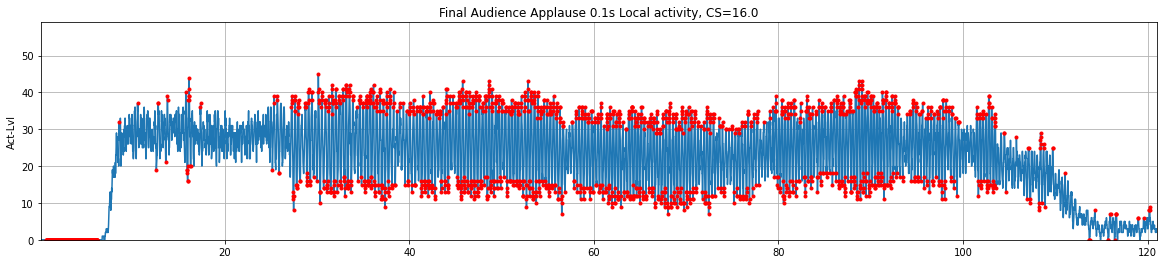

In [203]:
A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
fig = A['Activity-levels'].plot(figsize=[20,4])
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.')
else:
    B['Activity-levels'].plot(style='y.')
plt.ylim([0,59])
plt.xlim([A.index[0],A.index[-1]])
plt.ylabel('Act-Lvl')
plt.grid()
plt.title('Final Audience Applause ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
plt.savefig('Applause_Final_Alignment_01.png',dpi = 400)
plt.show()

Testing out plausible windows of synchrony (framesize for counting concurrent claps) given the uncertainty around noise in the alignment. Tried a range of 40 ms (two samples) to 200 ms. The agregate coordination score max out for all conditions and the activity level peaks (in red) overlap substantially across this parameter range (for a threshold of alpha = 0.01). However, the larger windows blur the lows substantially, shifting the distribution of activity levels quite high. As a compromise between known precision issues and clarity of activity-counts, we can settle on the compromise with 100 ms (0.1 s) as window of synch. 

In [182]:
windows = np.arange(0.04,0.2,0.04)
windows

array([0.04, 0.08, 0.12, 0.16])

46.78997826576233
92.05261611938477
137.21502423286438
182.86875104904175


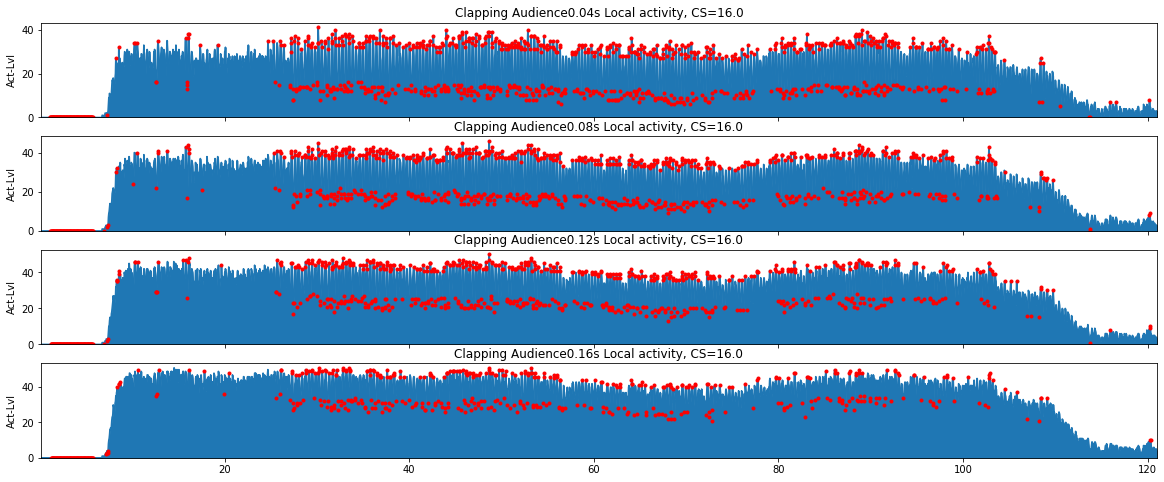

In [196]:
fig, axs = plt.subplots(len(windows),1, sharex='all',figsize=(20,len(windows)*2))
tic = time.time()
    
for j in range(len(windows)):
    FrameSize = windows[j]
    stest = act.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']
    C = stest['CoordScore']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot(ax=axs[j])
    if C >=-np.log10(alpha):
        B['Activity-levels'].plot(style='r.',ax=axs[j])
    else:
        B['Activity-levels'].plot(style='y.',ax=axs[j])
#     axs[j].set_ylim(0,19)
    axs[j].set_xlim(A.index[0],A.index[-1])
    axs[j].set_ylabel('Act-Lvl')

    axs[j].set_title('Clapping Audience' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
    print(time.time()-tic)
#     os.chdir('./peaks')
#     stest['ActivityPeaks'].to_csv(work+'_PL_'+ str(FrameSize) + 's_peaks.csv')
#     os.chdir('..')
#os.chdir('./plots')
plt.savefig('L_P_claps_aligned.png',dpi = 400)
#os.chdir('..')
plt.show()

## Clap regularity check
Are clapping patterns different during asynchronous clapping and synchronous clapping?

Analysis using pinguin anova, mixed.

Check clapping regularity in three 3s intervals per condition: 

1. Initial uncoordinated clapping interval (7s-25s)
2. Lasting coordinated interval (30s-100s)
3. Mixed intervals (75s-82s?, 100s onward) ? 

Dependent Traits of interest:
1. Median ICI
2. ICI std 
3. ICI quartile difference
4. Median ICI deviance (avg distance from each clap to the closest ISO sequence clap, after max alignment, need to write function TODO)

Independent traits:
Interval onset, Interval condition, participant, 


In [353]:
df_OnlyClaps = df_claps.astype(bool).astype(int)

In [356]:
# excerpt df_claps with time
t_interval = 3 # 3 second intervals for evaluating clapping
t_0 = 10 # onset of interval being evaluated
sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
sub_claps

0   1   2   3   4   5   6   7   8   9   ...  49  50  51  52  53  54  \
10.00   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
10.02   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
10.04   0   0   0   0   0   0   0   0   0   0  ...   0   1   0   0   0   0   
10.06   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
10.08   0   0   0   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
12.92   0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   
12.94   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
12.96   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
12.98   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
13.00   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   

       55  56  57  58  
10.00   0   0   0   0  
10.02   0   0   0   0  
10.04   0   0   0   0  
10.06   0   0   0   0  
10.08   0   0   0   0  
...    ..  ..  ..  ..  
12.92   0   0   0   1  
12.94   0   0   1   0  
12.96   0   0   0   0  
12.98   0   0   0   0  
13.00   0   0   0   0  

[151 rows x 59 columns]

In [368]:
# extract key features for a single participant during interval
cols = sub_claps.columns
partn = cols[0]
ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
[ici.median(),ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),ici.mean(),ici.std()]



[0.3600000000000012,
 0.03999999999999915,
 0.3685714285714286,
 0.03236694374850747]

In [376]:
# build database of clapping behaviour over measured intervals
Clap_Style = pd.DataFrame(columns = ['Interval_start','Interval_duration','Interval_condition','Participant','ICI_Median','ICI_Quartiles','ICI_Mean','ICI_STD','Clap_Count'])
Clap_Style

clap_stats = []
cols = sub_claps.columns
for partn in cols:
    ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
    #[ici.median(),ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),ici.mean(),ici.std()]
    these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':'Initial_Scattered',
       'Participant':partn, 'ICI_Median':ici.median(), 'ICI_Quartiles':np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5), 'ICI_Mean':ici.mean(), 'ICI_STD':ici.std(),
       'Clap_Count':len(ici)}
    clap_stats.append(these_claps)
Clap_Style = pd.concat([Clap_Style, pd.DataFrame(clap_stats)], ignore_index=True)

In [435]:
# build database of clapping behaviour over measured intervals
Clap_Style = pd.DataFrame(columns = ['Interval_start','Interval_duration','Interval_condition','Participant','ICI_Median','ICI_Quartiles','ICI_Mean','ICI_STD','Clap_Count'])
t_interval = 3
sampletimes = [10, 14, 18, 20, 35, 50, 65, 80, 104,108,112]
sampleconditions = ['Initial','Initial','Initial','Initial','Synched','Synched','Synched','Synched','End','End','End']
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    t_con = sampleconditions[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':ici.median(), 'ICI_Quartiles':np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5), 
           'ICI_Mean':ici.mean(), 'ICI_STD':ici.std(), 'Clap_Count':len(ici)}
        clap_stats.append(these_claps)
    Clap_Style = pd.concat([Clap_Style, pd.DataFrame(clap_stats)], ignore_index=True)

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/num

# Individual claps

In [436]:
Clap_Style

Interval_start Interval_duration Interval_condition Participant  \
0               10                 3            Initial           0   
1               10                 3            Initial           1   
2               10                 3            Initial           2   
3               10                 3            Initial           3   
4               10                 3            Initial           4   
..             ...               ...                ...         ...   
644            112                 3                End          54   
645            112                 3                End          55   
646            112                 3                End          56   
647            112                 3                End          57   
648            112                 3                End          58   

     ICI_Median  ICI_Quartiles  ICI_Mean   ICI_STD Clap_Count  
0          0.36           0.04  0.368571  0.032367          8  
1          0.38           0.08  0.354286  0.052554          8  
2          0.32           0.02  0.322500  0.016690          9  
3          0.27           0.02  0.272000  0.019322         11  
4          0.38           0.18  0.433333  0.099331          7  
..          ...            ...       ...       ...        ...  
644         NaN            NaN       NaN       NaN          1  
645         NaN            NaN       NaN       NaN          0  
646         NaN            NaN       NaN       NaN          0  
647        0.34           0.20  0.366667  0.102632          4  
648         NaN            NaN       NaN       NaN          0  

[649 rows x 9 columns]

In [437]:
Clap_Style.columns
cstats = Clap_Style.where(Clap_Style['Clap_Count']>0)
len(cstats)
cstats = cstats.dropna()
Clap_Style.columns

Index(['Interval_start', 'Interval_duration', 'Interval_condition',
       'Participant', 'ICI_Median', 'ICI_Quartiles', 'ICI_Mean', 'ICI_STD',
       'Clap_Count'],
      dtype='object')

In [450]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Median', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))

Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.108  1.959  94.041  5.793  0.004

In [451]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Quartiles', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
aov.round(3)

Source      W  ddof1   ddof2    F  p-unc
Friedman  Interval_condition  0.012  1.959  94.041  0.6  0.547

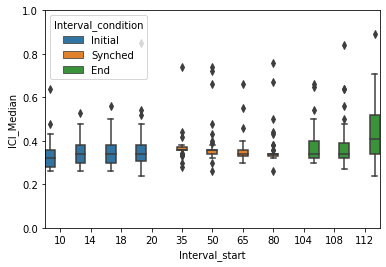

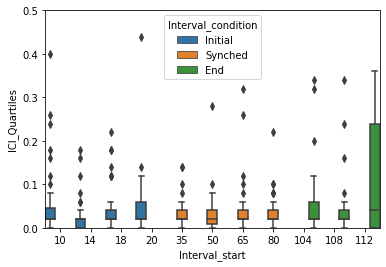

In [452]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Median', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Median",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
aov = pg.friedman(dv='ICI_Quartiles', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_Quartiles',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

In [453]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Mean', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
aov.round(3)

Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.088  1.959  94.041  4.625  0.013

In [454]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_STD', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
aov.round(3)

Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.068  1.958  92.042  3.413  0.038

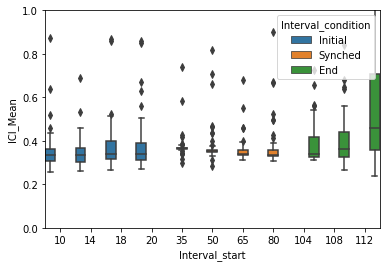

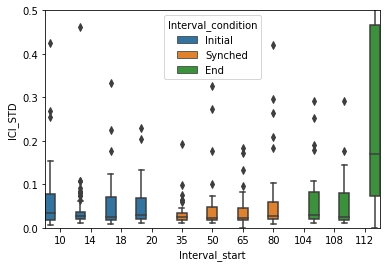

In [446]:
sns.boxplot(x = "Interval_start",y="ICI_Mean",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
sns.boxplot(x = "Interval_start",y='ICI_STD',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

# Transition to synch clapping

Identifying the transition to synchronous clapping with features identified 


(0.0, 0.8)

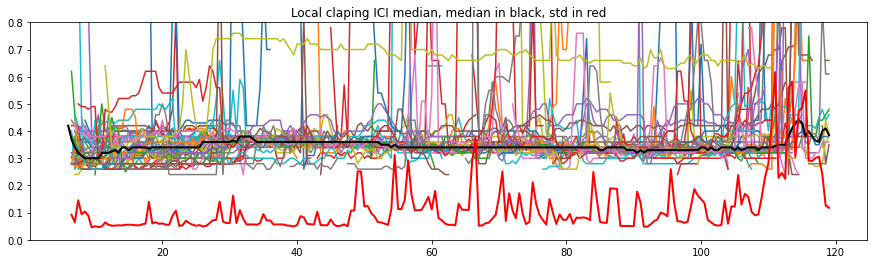

In [696]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = {}
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI median, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

In [697]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats

Median LowerQ UpperQ Midrange NotNa_C   NotNa_p
6.0     0.42   0.42   0.42      0.0     1.0  0.016949
6.5     0.37   0.28   0.39     0.11    15.0  0.254237
7.0     0.34    0.3    0.4      0.1    34.0  0.576271
7.5     0.32   0.29   0.38     0.09    47.0   0.79661
8.0     0.31   0.28   0.36     0.08    49.0  0.830508
...      ...    ...    ...      ...     ...       ...
117.0  0.365   0.32   0.41     0.09    10.0  0.169492
117.5   0.36   0.32   0.45     0.13     9.0  0.152542
118.0    0.4   0.34   0.48     0.14    10.0  0.169492
118.5   0.41   0.36   0.46      0.1    10.0  0.169492
119.0  0.385   0.36   0.46      0.1    12.0   0.20339

[227 rows x 6 columns]

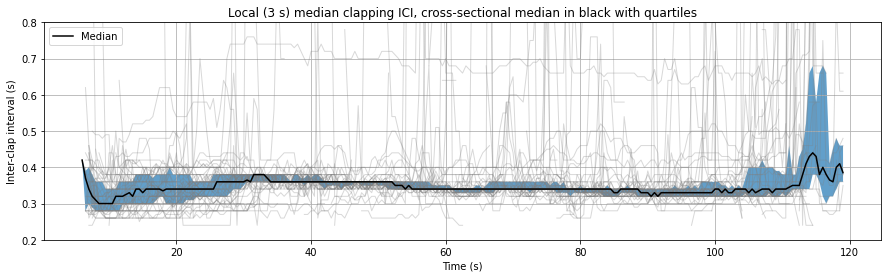

In [662]:
fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_medians_QuartileTS.png',dpi=400)
plt.show()


In [731]:
60/0.40

150.0

In [732]:
60/0.28

214.28571428571428

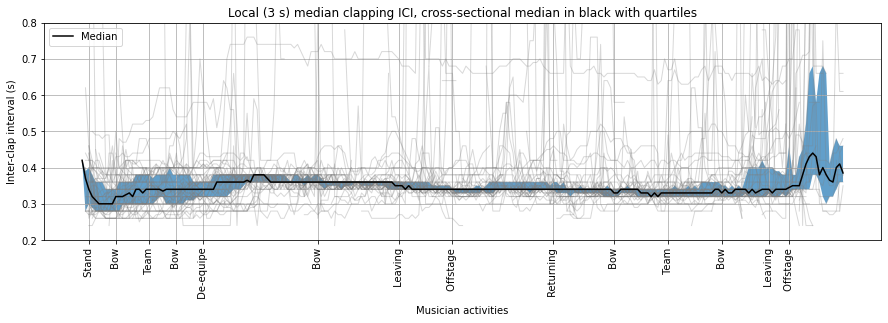

In [693]:
fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
#plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.xlabel('Musician activities')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_medians_QuartileTS_ME.png',dpi=400)
plt.show()


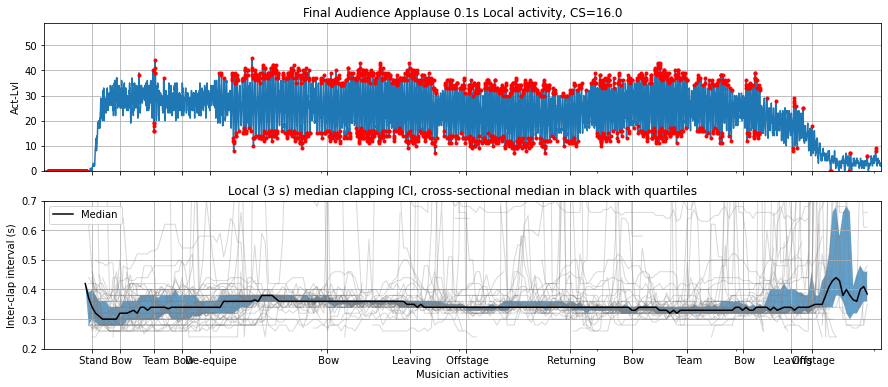

In [714]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=[15,6])

A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
A['Activity-levels'].plot(ax=ax1)
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.',ax=ax1)
else:
    B['Activity-levels'].plot(style='y.',ax=ax1)
ax1.set_ylim([0,59])
ax1.set_xlim([A.index[0],A.index[-1]])
ax1.set_ylabel('Act-Lvl')
ax1.grid()
ax1.set_title('Final Audience Applause ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
# plt.savefig('Applause_Final_Alignment_01.png',dpi = 400)
# plt.show()



df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax2)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black",ax = ax2)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax2.fill_between(x,y1,y2,alpha = 0.7)
ax2.set_ylim([0.2,0.7])
ax2.grid()
#plt.xlabel('Time (s)')
ax2.set_xticks(musician_times.TIME.values)
ax2.set_xticklabels(musician_times.LABEL.values)
ax2.set_xlabel('Musician activities')
ax2.set_ylabel('Inter-clap interval (s)')
ax2.set_title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_ACT.png',dpi=400)
plt.show()


(0.0, 0.8)

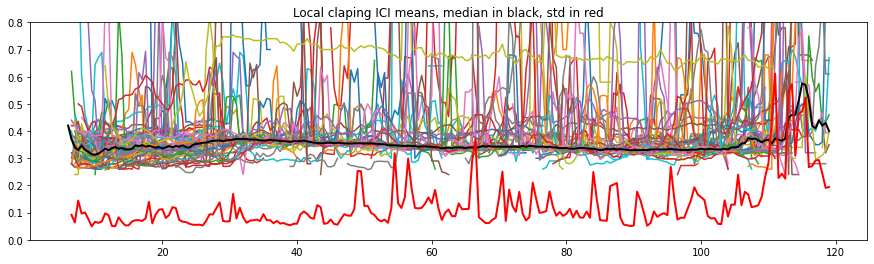

In [715]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = {}
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmean(ici)
            #these_claps[partn]=np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI means, median in black, std in red')
#plt.title('Local claping ICI MiddleRange, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

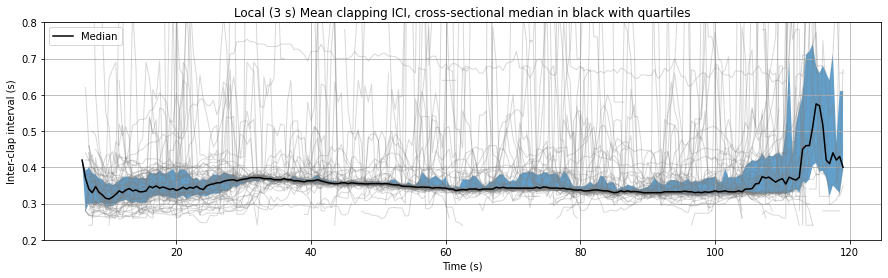

In [716]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats
fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Mean clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_means_QuartileTS.png',dpi=400)
plt.show()


In [726]:
df_feats.loc[100:105]

Median    LowerQ    UpperQ Midrange NotNa_C   NotNa_p
100.0     0.335  0.328889  0.374286   0.0454    53.0  0.898305
100.5    0.3325    0.3275      0.36   0.0325    52.0  0.881356
101.0  0.333333     0.328      0.36    0.032    51.0  0.864407
101.5     0.335    0.3275  0.396667  0.06917    51.0  0.864407
102.0    0.3325    0.3275  0.371429  0.04393    51.0  0.864407
102.5    0.3325  0.328571  0.373333  0.04476    51.0  0.864407
103.0  0.332381     0.328  0.371429  0.04343    52.0  0.881356
103.5     0.335      0.33  0.377143  0.04714    52.0  0.881356
104.0    0.3325    0.3275      0.38   0.0525    52.0  0.881356
104.5      0.34  0.331111  0.403333  0.07222    47.0   0.79661
105.0      0.34      0.33  0.411429  0.08143    46.0  0.779661

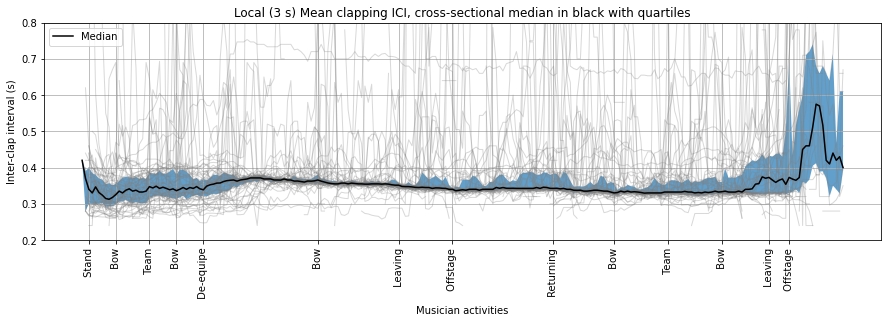

In [695]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats
fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
#plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.xlabel('Musician activities')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Mean clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_means_QuartileTS_ME.png',dpi=400)
plt.show()


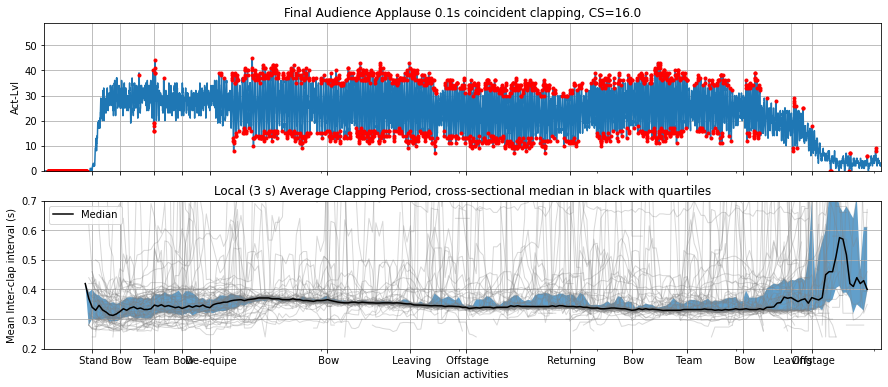

In [719]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=[15,6])

A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
A['Activity-levels'].plot(ax=ax1)
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.',ax=ax1)
else:
    B['Activity-levels'].plot(style='y.',ax=ax1)
ax1.set_ylim([0,59])
ax1.set_xlim([A.index[0],A.index[-1]])
ax1.set_ylabel('Act-Lvl')
ax1.grid()
ax1.set_title('Final Audience Applause ' + str(FrameSize) + 's coincident clapping, CS='+str(round(stest['CoordScore'],3)))
# plt.savefig('Applause_Final_Alignment_01.png',dpi = 400)
# plt.show()



df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax2)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black",ax = ax2)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax2.fill_between(x,y1,y2,alpha = 0.7)
ax2.set_ylim([0.2,0.7])
ax2.grid()
#plt.xlabel('Time (s)')
ax2.set_xticks(musician_times.TIME.values)
ax2.set_xticklabels(musician_times.LABEL.values)
ax2.set_xlabel('Musician activities')
ax2.set_ylabel('Mean Inter-clap interval (s)')
ax2.set_title('Local (3 s) Average Clapping Period, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_Mean_ICI_ACT.png',dpi=400)
plt.show()


(0.0, 0.8)

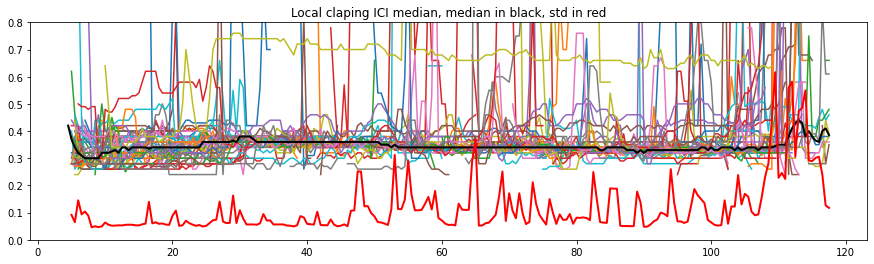

In [570]:
# build database of clapping behaviour over measured intervals
t_interval = 3
sampletimes = np.arange(0,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = {}
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI median, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

(0.0, 0.2)

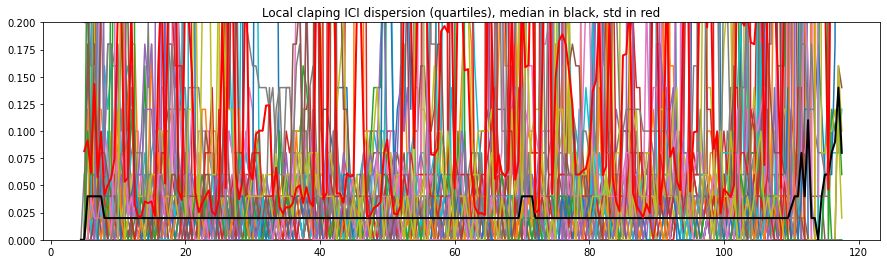

In [568]:
# build database of clapping behaviour over measured intervals
t_interval = 3
sampletimes = np.arange(0,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = {}
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI dispersion (quartiles), median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.2])

(0.0, 0.2)

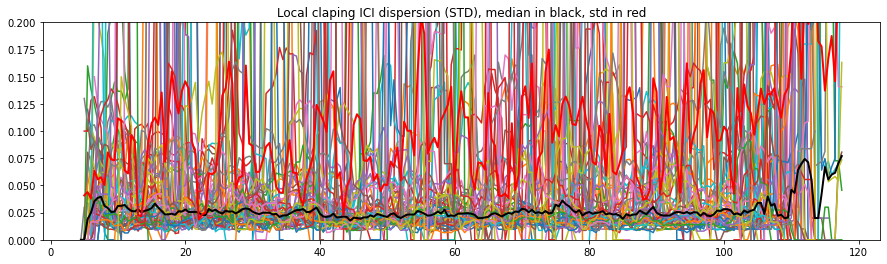

In [569]:
# build database of clapping behaviour over measured intervals
t_interval = 3
sampletimes = np.arange(0,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = {}
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanstd(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI dispersion (STD), median in black, std in red')
B = Clap_Feats.median(axis=1)

B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.2])

# beethoven applause

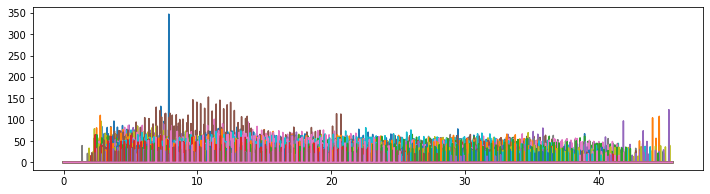

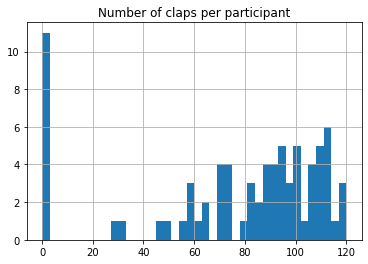

[77, 66]


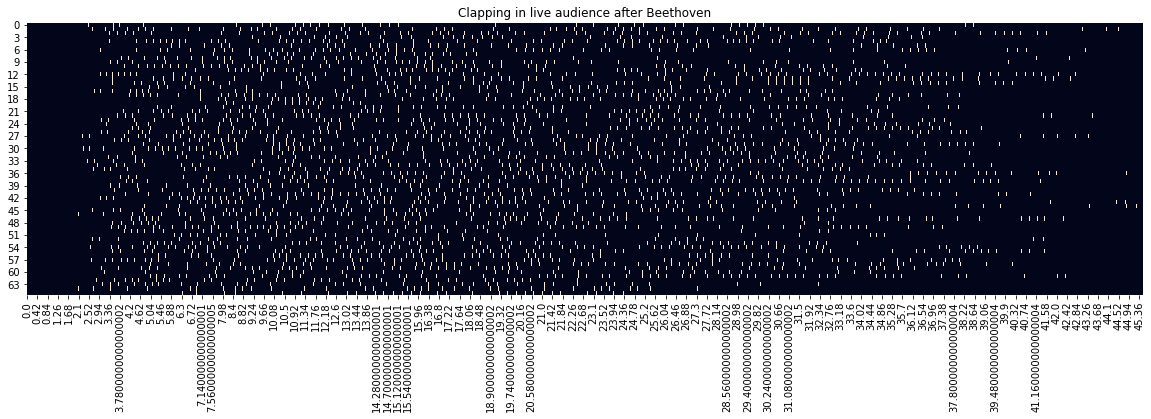

In [666]:
peaks = pd.read_csv('./Data/beethoven_clapping_section_accelerometer/beethoven_section_peaks.csv')
#peaks= peaks.set_index('index',drop = True)
peaks = peaks.fillna(0)
ts = pd.Series(np.arange(0,len(peaks))*0.02)
df_claps = pd.DataFrame(index = ts,data = peaks.drop('index',1).values)
df_claps.plot(figsize = [12,3],legend = False)
plt.show()
df_OnlyClaps = df_claps.astype(bool).astype(int)

df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>0])])
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>0]]
df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)

fig, ax = plt.subplots(figsize = [20,5])
chart = sns.heatmap(data=df_claps.transpose(), ax=ax,vmin=0, vmax=1,cbar=False)
#plt.xticks(concert_times.datetime_concert,concert_times.event, rotation='vertical')
#freq = int(round(len(aud_df)/len(ax.get_xticks())))
#ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Clapping in live audience after Beethoven')
#plt.savefig('claptimes_finale.png')
plt.show()

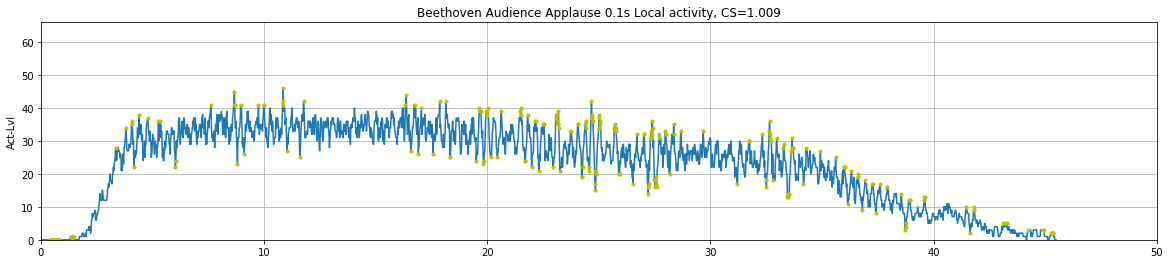

In [677]:
actType = 'UBound'
HopSize = 0.02
Thresh = 0.5
FrameSize = 0.1
# Acts=act.activityCount(df_claps.loc[3:35,:],FrameSize,HopSize,Thresh,actType)
Acts=act.activityCount(df_claps,FrameSize,HopSize,Thresh,actType)

Acts= Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total'])
ShuffleRange = 1
Iter = 1000
alpha = 0.05

stest = act.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
fig = A['Activity-levels'].plot(figsize=[20,4])
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.')
else:
    B['Activity-levels'].plot(style='y.')
plt.ylim([0,66])
plt.xlim([0,50])
plt.ylabel('Act-Lvl')
plt.grid()
plt.title('Beethoven Audience Applause ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
plt.savefig('Applause_Beethoven_Alignment_01_sub.png',dpi = 400)
plt.show()

In [471]:
df_claps

0    1    2    3    4    5    6    7    8    9   ...   56   57   58  \
0.00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
0.02   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
0.04   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
0.06   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
0.08   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
45.42  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
45.44  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
45.46  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
45.48  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
45.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

        59   60   61   62   63   64   65  
0.00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.02   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.04   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.06   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.08   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
45.42  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
45.44  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
45.46  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
45.48  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
45.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2276 rows x 66 columns]

In [467]:
# build database of clapping behaviour over measured intervals
Clap_Style = pd.DataFrame(columns = ['Interval_start','Interval_duration','Interval_condition','Participant','ICI_Median','ICI_Quartiles','ICI_Mean','ICI_STD','Clap_Count'])
t_interval = 3
sampletimes = [5, 10, 15, 20, 25, 32]
sampleconditions = ['Initial','Initial','Initial','Synched','Synched','Synched']
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    t_con = sampleconditions[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':ici.median(), 'ICI_Quartiles':np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5), 
           'ICI_Mean':ici.mean(), 'ICI_STD':ici.std(), 'Clap_Count':len(ici)}
        clap_stats.append(these_claps)
    Clap_Style = pd.concat([Clap_Style, pd.DataFrame(clap_stats)], ignore_index=True)

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/num

                      Source     W  ddof1   ddof2     F  p-unc
Friedman  Interval_condition  0.36  0.969  62.031  36.0    0.0


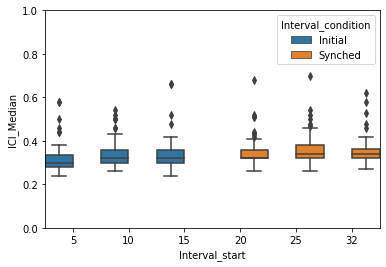

                      Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.007  0.969  62.031  0.435  0.506


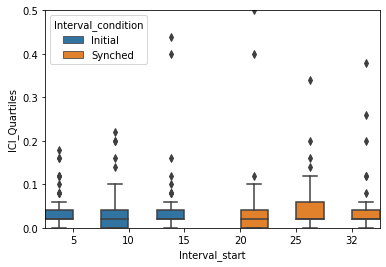

In [468]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Median', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Median",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
aov = pg.friedman(dv='ICI_Quartiles', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_Quartiles',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

                      Source     W  ddof1   ddof2     F  p-unc
Friedman  Interval_condition  0.36  0.969  62.031  36.0    0.0


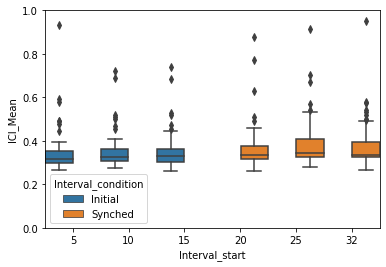

                      Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.004  0.969  61.031  0.247  0.613


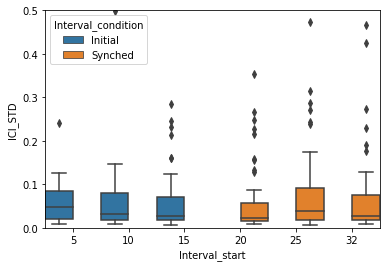

In [469]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Mean', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Mean",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
aov = pg.friedman(dv='ICI_STD', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_STD',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

(0.0, 0.8)

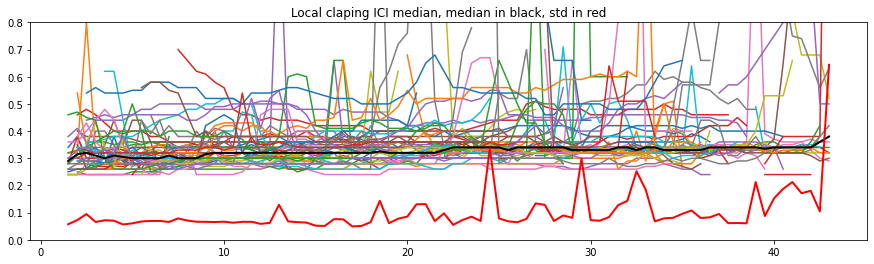

In [675]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,45-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = {}
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[10,4])
plt.title('Local claping ICI median, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

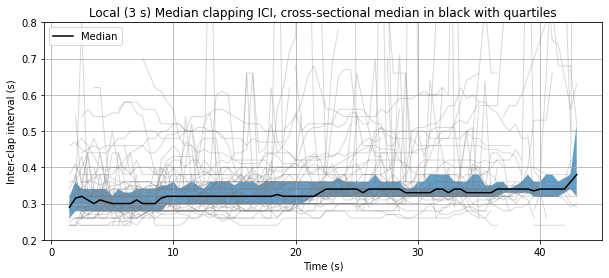

In [676]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats
fig,ax = plt.subplots(1,1,figsize=[10,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('BeethovenApplause_Local_ICI_medians_QuartileTS.png',dpi=400)
plt.show()


(0.0, 0.8)

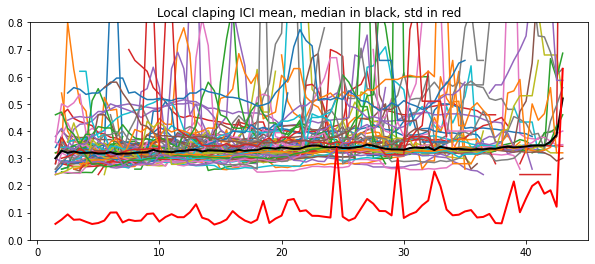

In [672]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,45-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = {}
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmean(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[10,4])
plt.title('Local claping ICI mean, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

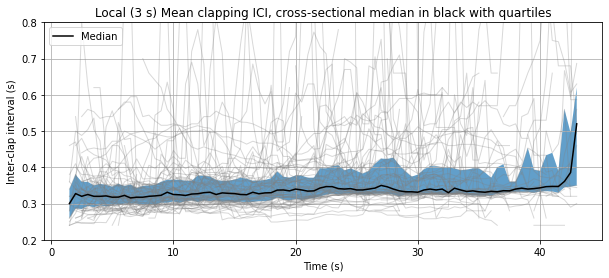

In [674]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats
fig,ax = plt.subplots(1,1,figsize=[10,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Mean clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('BeethovenApplause_Local_ICI_means_QuartileTS.png',dpi=400)
plt.show()
